In [4]:
#############################################################
# Chat
#
# Step 1: Overview of the workflow for RAG 
# Step 2: Load document and create VectorDB
# Step 3: Similarity Search to select relevant chunks (splits)
# Step 4: Create LLM
# Step 5: RetrievalQA Chain
#     Step 5.1: Craete a prompt template
#     Step 5.2: Create QA Chain Prompt from prompt template
#     Step 5.3: Run QA chain from the "QA Chain Prompt" 
#           using "Stuff" chain type
# Step 6: ConversationalRetrievalChain 
#      Step 6.1: Create Memory 
#      Step 6.2: QA with ConversationalRetrievalChain
#      Step 6.3: Test ConversationalRetrievalChain
#          Step 6.3.1: First Question
#          Step 6.3.2: Follow-up Question
# Step 7: Create a chatbot that works on your documents
#      Step 7.1: Create Business Logic 
#      Step 7.2: Create a chatbot GUI
#############################################################


#############################################################
# Step 1: Overview of the workflow for
#
#      Retrieval Augmented Generation (RAG)
#
# References: Vectorstores and Embeddings & 
#             Vectorstore Retrieval
# 1. Document Loading
# 2. Splitting the content to create chunks (splits)
# 3. Indexing each chunk (split) by embeddings
# 4. Storage - Vectorstore
# 5. Retrieval to select relevant chunks (splits)
#    - Vectorstore Retrieval by Similarity Search
#    - Traditional Retrieval by SVM or TF-IDF
#############################################################

# In[ ]:


#############################################################
# Step 1.1: Set up environment
#
# - OpenAI key setup 
# - LLM selection
#############################################################
import sys
sys.path.append('../..')

import panel as pn  # GUI
pn.extension()



In [6]:
#############################################################
# Step 1.1.1: OpenAI key setup
#############################################################
import os
from openai import OpenAI
# read the api key from environment variable
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [7]:
#############################################################
# Step 1.1.2: LLM model selection
#
# The code below was added to assign the openai LLM version 
# filmed until it is deprecated, currently in Sept 2023. 
# LLM responses can often vary, but the responses may be 
# significantly different when using a different 
# model version.
#############################################################
import datetime
current_date = datetime.datetime.now().date()
if current_date < datetime.date(2023, 9, 2):
    llm_name = "gpt-3.5-turbo-0301"
else:
    llm_name = "gpt-3.5-turbo"
print(llm_name)


gpt-3.5-turbo


In [8]:
#############################################################
# Step 1.2: Experiment on "LangChain plus platform" - optional
#
# - If you wish to experiment on 
#     `LangChain plus platform`:
# 
#   + Go to [langchain plus platform](
#     https://www.langchain.plus/) and sign up
#   + Create an api key from your account's settings
#   + Use this api key in the code below 
#
#        import os
#
#        os.environ["LANGCHAIN_TRACING_V2"] = "true"
#        os.environ["LANGCHAIN_ENDPOINT"] = 
#            "https://api.langchain.plus"
#        os.environ["LANGCHAIN_API_KEY"] = "..."
#############################################################
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

In [9]:
#############################################################
# Step 2: Load document and create VectorDB
#
# Before this step, you must have done
# 1. Document Loading
# 2. Splitting the content to create chunks (splits)
# 3. Indexing each chunk (split) by embeddings
# 4. Storage - Vectorstore
#    - The result is put into the vecstore: docs/chroma/ 
#
#========================================================
#
# References: Vectorstores and Embeddings &
#             Vectorstore Retrieval
# 1. Document Loading
# 2. Splitting the content to create chunks (splits)
# 3. Indexing each chunk (split) by embeddings
# 4. Storage - Vectorstore
# 5. Retrieval to select relevant chunks (splits)
#    - Vectorstore Retrieval by Similarity Search
#    - Traditional Retrieval by SVM or TF-IDF
#############################################################
persist_directory = 'docs/chroma/'
embedding = OpenAIEmbeddings()
vectordb = Chroma(persist_directory=persist_directory, 
                  embedding_function=embedding)


In [10]:
#############################################################
# Step 3: Similarity Search to select relevant chunks (splits)
#
# Vectorstore Retrieval by Similarity Search
#
# References: Vectorstores and Embeddings &
#             Vectorstore Retrieval
# 1. Document Loading
# 2. Splitting the content to create chunks (splits)
# 3. Indexing each chunk (split) by embeddings
# 4. Storage - Vectorstore
# 5. Retrieval to select relevant chunks (splits)
#    - Vectorstore Retrieval by Similarity Search
#    - Traditional Retrieval by SVM or TF-IDF
#############################################################
question = "What are courses offered?"
docs = vectordb.similarity_search(question,k=3)
len(docs)

3

In [11]:
#############################################################
# Step 4: Create LLM
#############################################################
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model_name=llm_name, temperature=0)
llm.predict("Hello world!")

'Hello! How can I assist you today?'

In [12]:
#############################################################
# Step 5: RetrievalQA Chain
#
# - Use Customer Prompts with Context 
# - Does not use Memory
#############################################################

#############################################################
# Step 5.1: Craete a prompt template
#
# - Define a prompt template which has
#   + Some instructions about how to use the following pieces 
#     of context
#   + A placeholder for a context variable.
#     - This is where the documents will go 
#   + A placeholder for the questions variable. 
#############################################################
from langchain.prompts import PromptTemplate

template = """Use the following pieces of \
   context to answer \
   the question at the end. If you don't know \
   the answer, \
   just say that you don't know, don't try \
   to make up an \
   answer. Use three sentences maximum. \
   Keep the answer as \
   concise as possible. Always say \
   "thanks for asking!" \
   at the end of the answer. 
{context}
Question: {question}
Helpful Answer:"""

In [14]:
#############################################################
# Step 5.2: Create QA Chain Prompt from prompt template
#############################################################
QA_CHAIN_PROMPT = PromptTemplate(
     input_variables=["context", "question"],
     template=template,)

#############################################################
# Step 5.3: Run QA chain from the "QA Chain Prompt" 
#           using "Stuff" chain type
#############################################################
from langchain.chains import RetrievalQA

question = "Is scholarship available?"
qa_chain = RetrievalQA.from_chain_type(llm,
   retriever=vectordb.as_retriever(),
   return_source_documents=True,
   chain_type_kwargs={"prompt": QA_CHAIN_PROMPT})


result = qa_chain({"query": question})
result["result"]

'Yes, the scholarship is available to current students at SFBU who meet the qualifications and submit their application by the deadline of June 30th. Thanks for asking!'

In [15]:
#############################################################
# Step 6: ConversationalRetrievalChain 
#
# - Use Memory
#############################################################

#############################################################
# Step 6.1: Create Memory 
#############################################################

# In[ ]:


from langchain.memory import ConversationBufferMemory

memory = ConversationBufferMemory(
    memory_key="chat_history",
    # Set return messages equal true
    # - Return the chat history as a  list of messages 
    #   as opposed to a single string. 
    # - This is  the simplest type of memory. 
    #   + For a more in-depth look at memory, go back to  
    #     the first class that I taught with Andrew.  
    return_messages=True
)


In [16]:
#############################################################
# Step 6.2: QA with ConversationalRetrievalChain
#############################################################

from langchain.chains import ConversationalRetrievalChain

retriever=vectordb.as_retriever()
qa = ConversationalRetrievalChain.from_llm(
    llm,
    retriever=retriever,
    memory=memory
)


In [18]:
#############################################################
# Step 6.3: Test ConversationalRetrievalChain
#############################################################

#############################################################
# Step 6.3.1: First Question
#############################################################
question = "Is scholarship available?"
result = qa({"question": question})

# In[ ]:

result['answer']

'Yes, scholarships are available at SFBU for current students pursuing degrees. Up to ten $1,000 scholarships are awarded to qualified students in the fall trimester. The application deadline is June 30th, and there are specific qualifications that need to be met.'

In [19]:
#############################################################
# Step 6.3.2: Follow-up Question
#############################################################
question = "why are those prerequesites needed?"
result = qa({"question": question})

# In[ ]:

result['answer']

'To apply for scholarships at SFBU, students must meet the following qualifications:\n1. Completed at least two trimesters of coursework towards their degree goal at SFBU.\n2. Maintained a cumulative GPA of at least 3.80 at SFBU.\n3. Been recommended by at least one faculty member for the scholarship award.\n4. Be in good standing with the University.\n5. Be a contributing member of the SFBU Student Association or student extracurricular activities.\n6. Be an active member in at least one professional society.\n7. Submit a Statement of Purpose and give a presentation in an open forum.\n8. Have other special skills as required.\nFor F-1 International Students, additional documents are required, such as a financial support document and specific immigration-related documents.'

In [20]:
#############################################################
# Step 7: Create a chatbot that works on your documents
#############################################################


from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import DocArrayInMemorySearch
from langchain.chains import RetrievalQA,  ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain_openai import ChatOpenAI
from langchain_community.document_loaders.pdf import PyPDFLoader


# The chatbot code has been updated a bit 
# since filming. The GUI 
# appearance also varies depending on the 
# platform it is running on.


In [102]:
#############################################################
# Step 7.1: Create a chatbot that works on your documents
#
# - Create Business logic
#############################################################

#############################################################
# Step 7.1.1: load_db function
#############################################################
def load_db(file, chain_type, k):
    # load documents
    loader = PyPDFLoader(file)
    documents = loader.load()
    # split documents
    text_splitter = RecursiveCharacterTextSplitter(
           chunk_size=1000, 
           chunk_overlap=150)
    docs1 = text_splitter.split_documents(documents)
    # define embedding
    embeddings = OpenAIEmbeddings()
    # create vector database from data
    db = DocArrayInMemorySearch.from_documents(docs1, 
           embeddings)
    # define retriever
    retriever = db.as_retriever(search_type="similarity", 
           search_kwargs={"k": k})
    # create a chatbot chain. Memory is managed externally.
    qa = ConversationalRetrievalChain.from_llm(
        llm=ChatOpenAI(model_name=llm_name, temperature=0), 
        chain_type=chain_type, 
        retriever=retriever, 
        return_source_documents=True,
        return_generated_question=True,
    )
    return qa 


In [103]:
import panel as pn
import param

#############################################################
# Step 7.1.2: cbfs class
#############################################################
class cbfs(param.Parameterized):
    chat_history = param.List([])
    answer = param.String("")
    db_query  = param.String("")
    db_response = param.List([])
    
    #########################################################
    # Step 7.1.2.1: init function
    #########################################################
    def __init__(self,  **params):
        super(cbfs, self).__init__( **params)
        self.panels = []
        self.loaded_file = "docs/2023Catalog.pdf"
        self.qa = load_db(self.loaded_file,"stuff", 4)
    
    #########################################################
    # Step 7.1.2.2: call_load_db function
    #########################################################
    def call_load_db(self, count):
        if count == 0 or file_input.value is None:  # init or no file specified :
            return pn.pane.Markdown(f"Loaded File: {self.loaded_file}")
        else:
            file_input.save("temp.pdf")  # local copy
            self.loaded_file = file_input.filename
            button_load.button_style="outline"
            self.qa = utils.load_db("temp.pdf", "stuff", 4)
            button_load.button_style="solid"
        self.clr_history()
        return pn.pane.Markdown(f"Loaded File: {self.loaded_file}")

    #########################################################
    # Step 7.1.2.3: convchain(self, query) function
    #########################################################
    def convchain(self, query):
        if not query:
            return pn.WidgetBox(pn.Row('User:', pn.pane.Markdown("", width=600)), scroll=True)
        result = self.qa({"question": query, "chat_history": self.chat_history})
        self.chat_history.extend([(query, result["answer"])])
        self.db_query = result["generated_question"]
        self.db_response = result["source_documents"]
        self.answer = result['answer'] 
        self.panels.extend([
            pn.Row('User:', pn.pane.Markdown(query, width=600)),
            pn.Row('SFBU_Bot:', pn.pane.Markdown(self.answer, width=600, style={'background-color': '#ffdfba'}))
        ])
        inp.value = ''  #clears loading indicator when cleared
        return pn.WidgetBox(*self.panels,scroll=True,height=300)

    #########################################################
    # Step 7.1.2.4: convchain(self) function
    #########################################################
    @param.depends('db_query ', )
    def get_lquest(self):
        if not self.db_query :
            return pn.Column(
                pn.Row(pn.pane.Markdown(f"Last question to DB:", styles={'background-color': '#baffc9'})),
                pn.Row(pn.pane.Str("no DB accesses so far"))
            )
        return pn.Column(
            pn.Row(pn.pane.Markdown(f"DB query:", styles={'background-color': '#baffc9'})),
            pn.pane.Str(self.db_query )
        )

    #########################################################
    # Step 7.1.2.5: get_sources function
    #########################################################
    @param.depends('db_response', )
    def get_sources(self):
        if not self.db_response:
            return 
        rlist=[pn.Row(pn.pane.Markdown(f"Result of DB lookup:", styles={'background-color': '#baffc9'}))]
        for doc in self.db_response:
            rlist.append(pn.Row(pn.pane.Str(doc)))
        return pn.WidgetBox(*rlist, width=600, scroll=True)
    
    #########################################################
    # Step 7.1.2.6: get_chats function
    #########################################################
    @param.depends('convchain', 'clr_history') 
    def get_chats(self):
        if not self.chat_history:
            return pn.WidgetBox(pn.Row(pn.pane.Str("No History Yet")), width=600, scroll=True)
        rlist=[pn.Row(pn.pane.Markdown(f"Current Chat History variable", styles={'background-color': '#baffc9'}))]
        for exchange in self.chat_history:
            rlist.append(pn.Row(pn.pane.Str(exchange)))
        return pn.WidgetBox(*rlist, width=600, scroll=True)


    #########################################################
    # Step 7.1.2.7: clr_history function
    #########################################################
    def clr_history(self,count=0):
        self.chat_history = []
        return 


In [104]:
#############################################################
# Step 7.2: Create a chatbot that works on your documents
#
# -  Create a chatbot GUI
#############################################################

# In[ ]:


# Integrate Business Logic and GUI
cb = cbfs()

#############################################################
# Step 7.2.1: Create File input
#############################################################
file_input = pn.widgets.FileInput(accept='.pdf')




In [105]:
#############################################################
# Step 7.2.2: Create buttons
#############################################################
button_load = pn.widgets.Button(name="Load DB", button_type='primary')
button_clearhistory = pn.widgets.Button(name="Clear History", button_type='warning')
button_clearhistory.on_click(cb.clr_history)
inp = pn.widgets.TextInput( placeholder='Enter text here…')

bound_button_load = pn.bind(cb.call_load_db, button_load.param.clicks)

In [106]:
#############################################################
# Step 7.2.3: Create conversation
#############################################################
conversation = pn.bind(cb.convchain, inp) 

In [107]:
#############################################################
# Step 7.2.4: Create jpg_pane 
#############################################################
jpg_pane = pn.pane.Image( './img/convchain.jpg')

In [108]:
tab1 = pn.Column(
    pn.Row(inp),
    pn.layout.Divider(),
    pn.panel(pn.bind(cb.convchain, inp) , loading_indicator=True, height=300),
    pn.layout.Divider(),
)


In [109]:
tab2= pn.Column(
    pn.panel(cb.get_lquest),
    pn.layout.Divider(),
    pn.panel(cb.get_sources ),
)


In [110]:
tab3= pn.Column(
    pn.panel(cb.get_chats),
    pn.layout.Divider(),
)


In [111]:
tab4=pn.Column(
    pn.Row( file_input, button_load, bound_button_load),
    pn.Row( button_clearhistory, pn.pane.Markdown("Clears chat history. Can use to start a new topic" )),
    pn.layout.Divider(),
    pn.Row(jpg_pane.clone(width=400))
)


In [112]:
dashboard = pn.Column(
    pn.Row(pn.pane.Markdown('# ChatWithYourData_Bot')),
    pn.Tabs(('Chat History', tab3),('Configure', tab4))
)
dashboard

Column
    [0] Row
        [0] Markdown(str)
    [1] Tabs
        [0] Column
            [0] ParamMethod(method, _pane=WidgetBox, defer_load=False)
            [1] Divider()
        [1] Column
            [0] Row
                [0] FileInput(accept='.pdf')
                [1] Button(button_type='primary', name='Load DB')
                [2] ParamFunction(function, _pane=Markdown, defer_load=False)
            [1] Row
                [0] Button(button_type='warning', name='Clear History')
                [1] Markdown(str)
            [2] Divider()
            [3] Row
                [0] Image(str, width=400)

In [113]:
#############################################################
# Step 7.2.6: Create dashboard 
#############################################################
dashboard = pn.Column(
    pn.Row(pn.pane.Markdown('# ChatWith_SFBU_Bot')),
    pn.Tabs(('Conversation', tab1), ('Database', tab2), 
        ('Chat History', tab3),('Configure', tab4))
)
dashboard

Column
    [0] Row
        [0] Markdown(str)
    [1] Tabs
        [0] Column
            [0] Row
                [0] TextInput(placeholder='Enter text here…')
            [1] Divider()
            [2] ParamFunction(function, _pane=WidgetBox, defer_load=False, height=300, loading_indicator=True)
            [3] Divider()
        [1] Column
            [0] ParamMethod(method, _pane=Column, defer_load=False)
            [1] Divider()
            [2] ParamMethod(method, _pane=Str, defer_load=False)
        [2] Column
            [0] ParamMethod(method, _pane=WidgetBox, defer_load=False)
            [1] Divider()
        [3] Column
            [0] Row
                [0] FileInput(accept='.pdf')
                [1] Button(button_type='primary', name='Load DB')
                [2] ParamFunction(function, _pane=Markdown, defer_load=False)
            [1] Row
                [0] Button(button_type='warning', name='Clear History')
                [1] Markdown(str)
            [2] Divider()
            [3] Row
                [0] Image(str, width=400)

In [24]:
! pip install docarray

  Obtaining dependency information for docarray from https://files.pythonhosted.org/packages/27/bf/90439e206a5d2df089e3467a703dfa0349f17d73f003ec51367db23bf8de/docarray-0.40.0-py3-none-any.whl.metadata
  Obtaining dependency information for types-requests>=2.28.11.6 from https://files.pythonhosted.org/packages/ce/ca/82c7f75616c524856488cece6b37e459de626cad49b2a24a0b571c20be06/types_requests-2.31.0.20240218-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.2/270.2 kB 3.7 MB/s eta 0:00:00a 0:00:01


In [114]:
# SCREENSHOTS

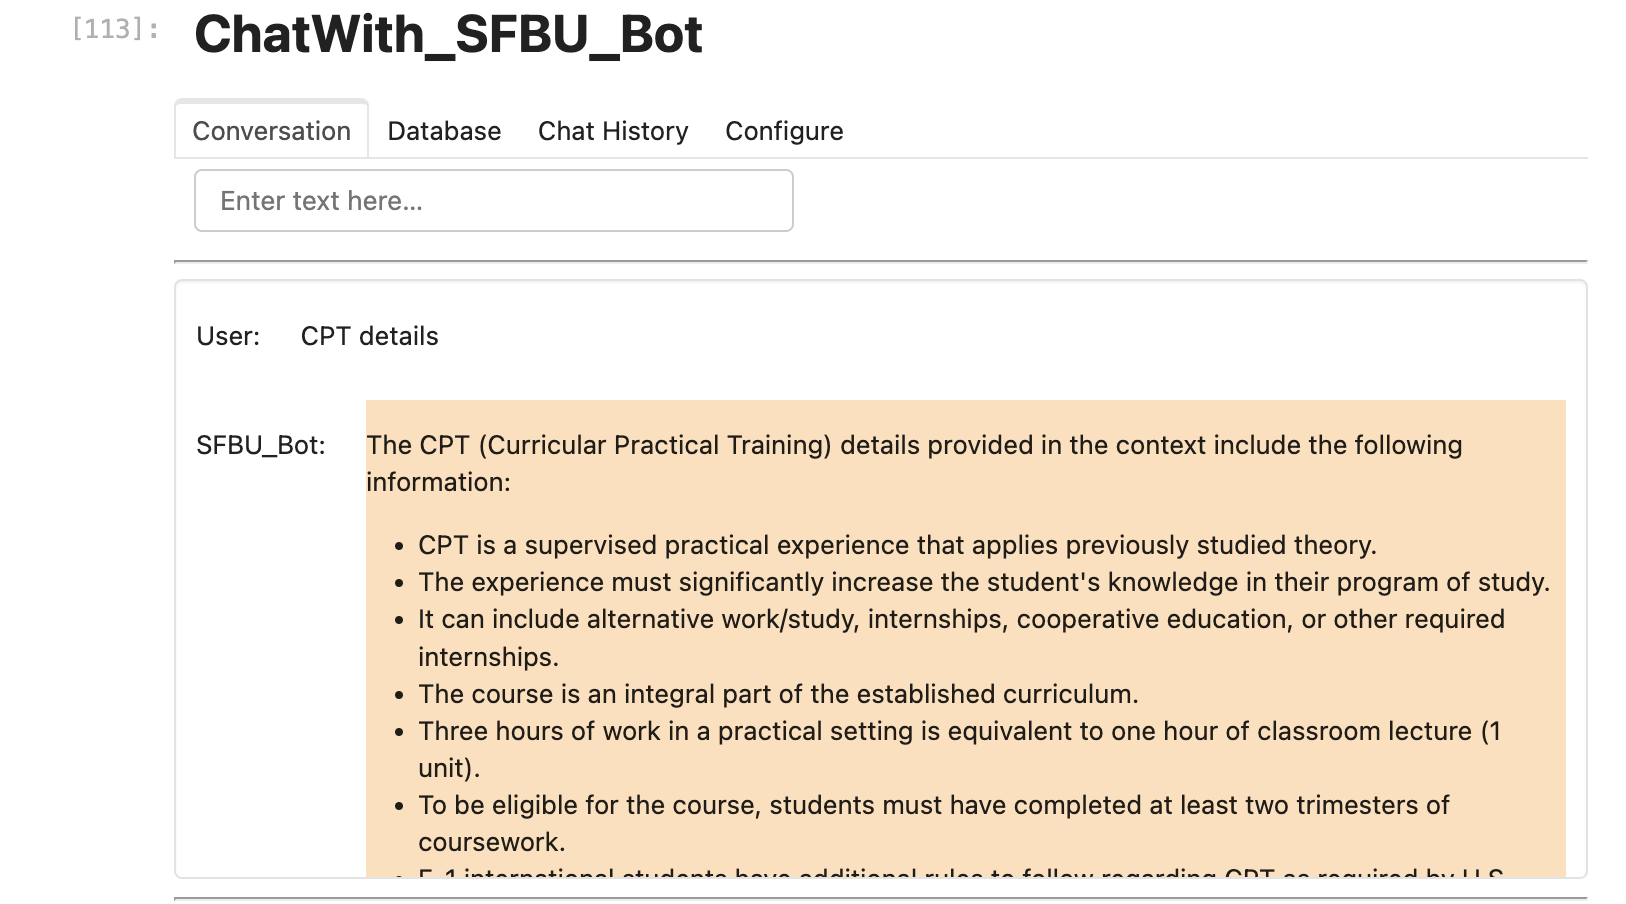

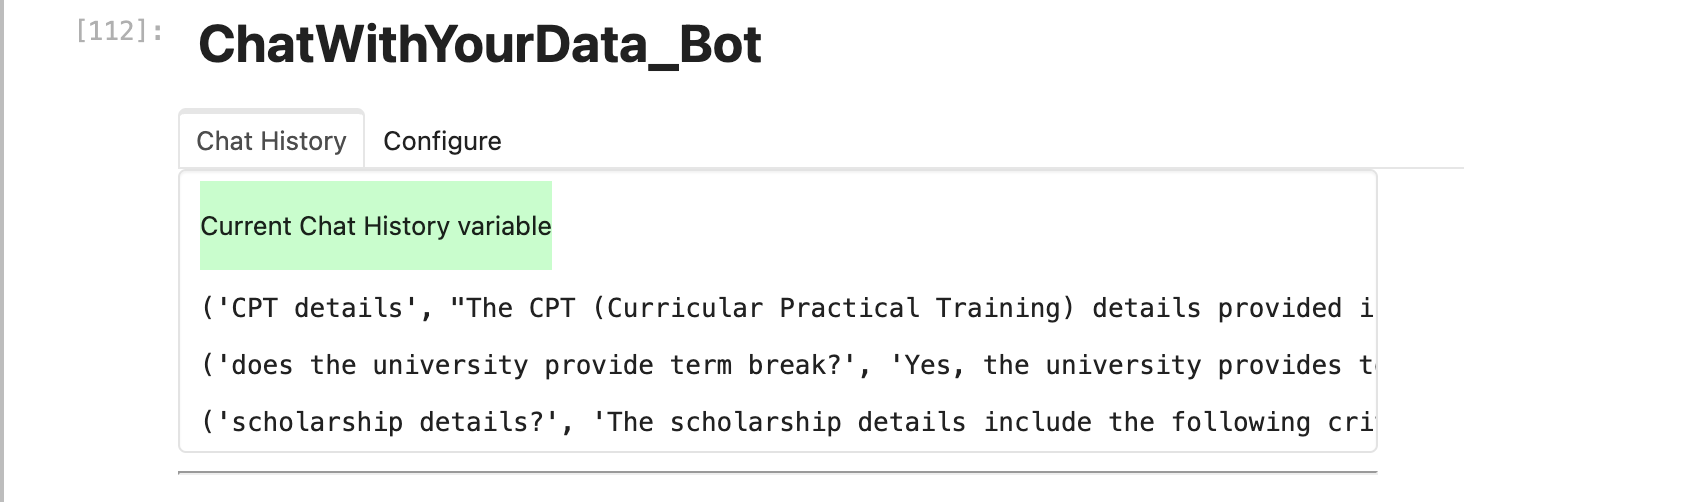

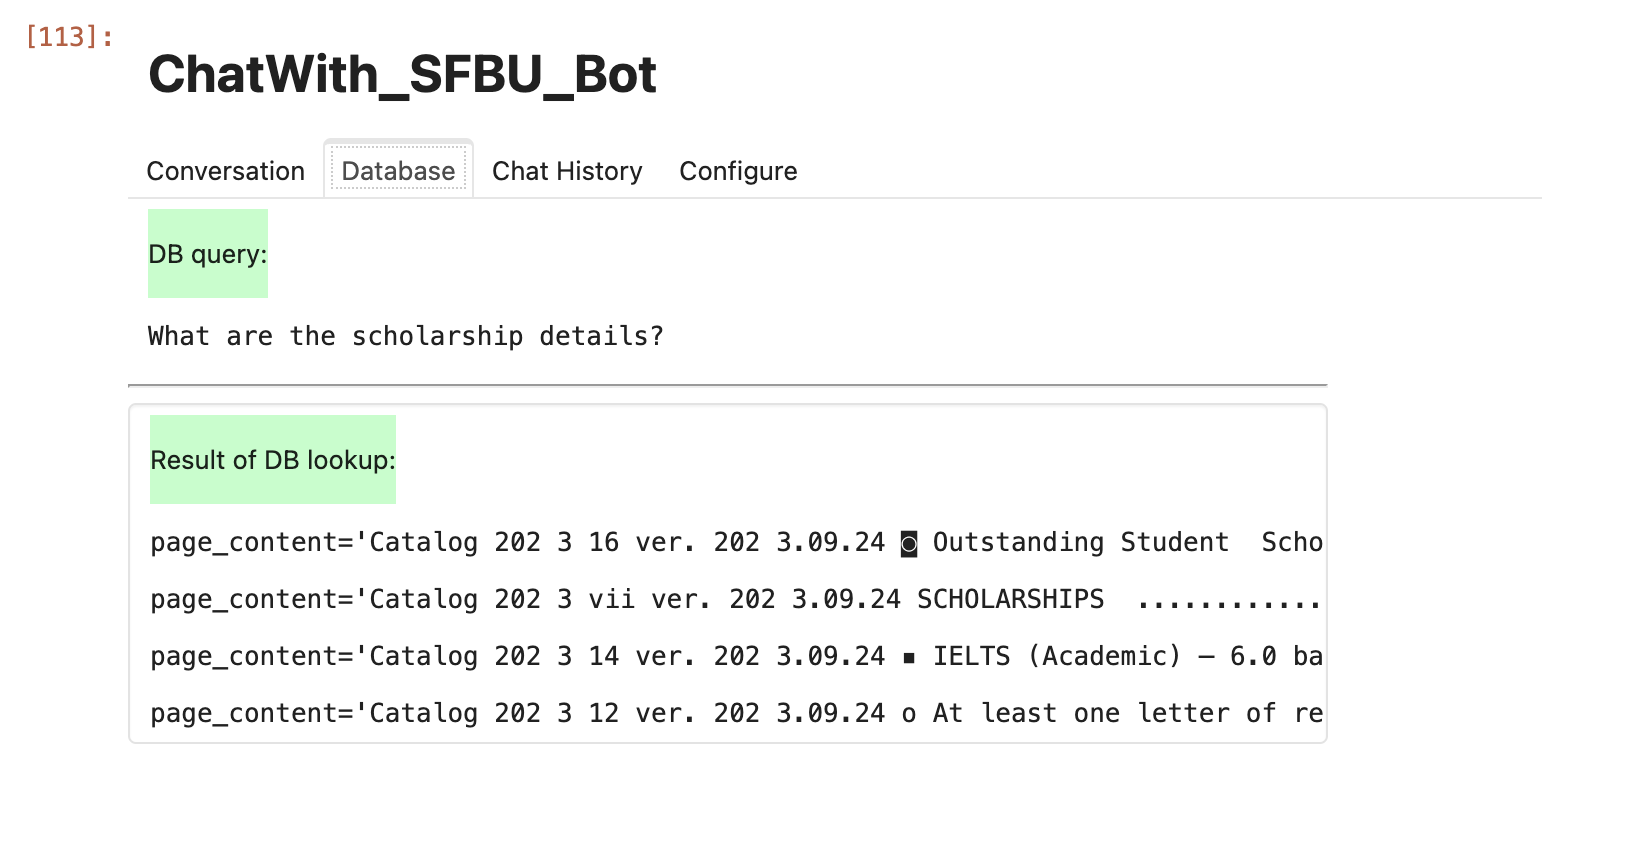

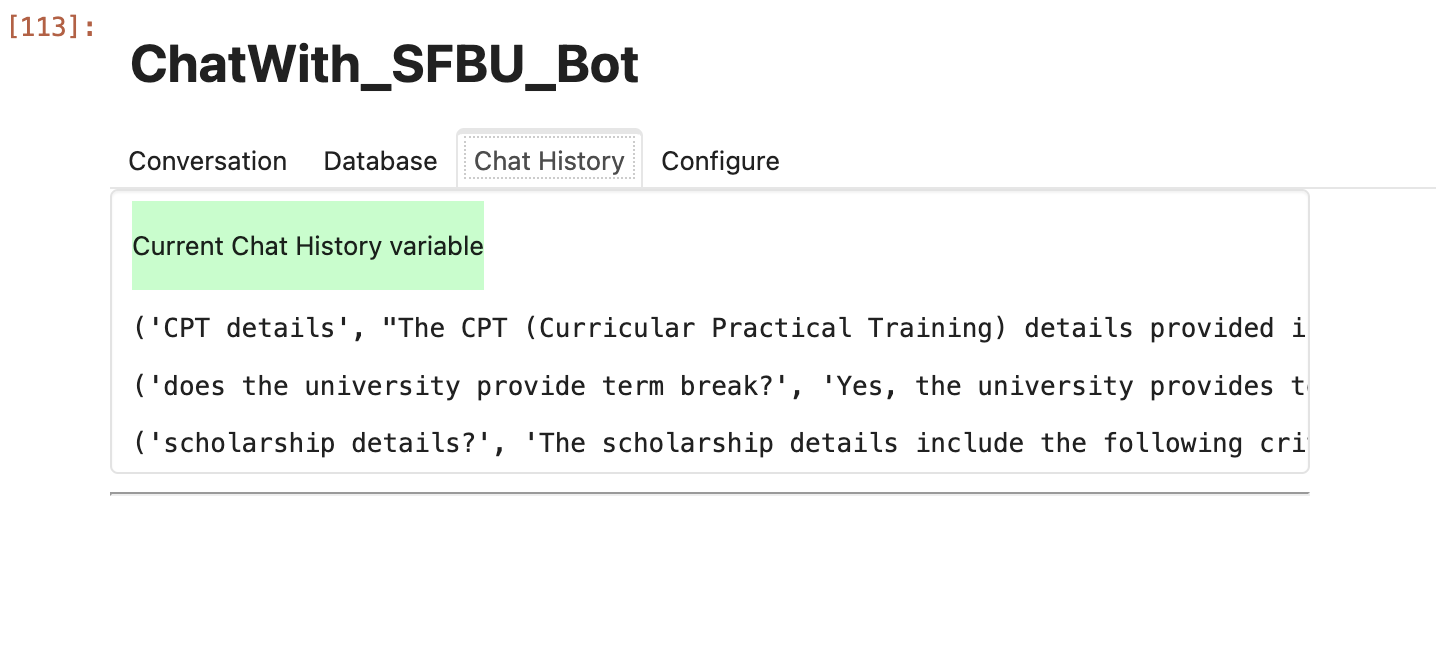

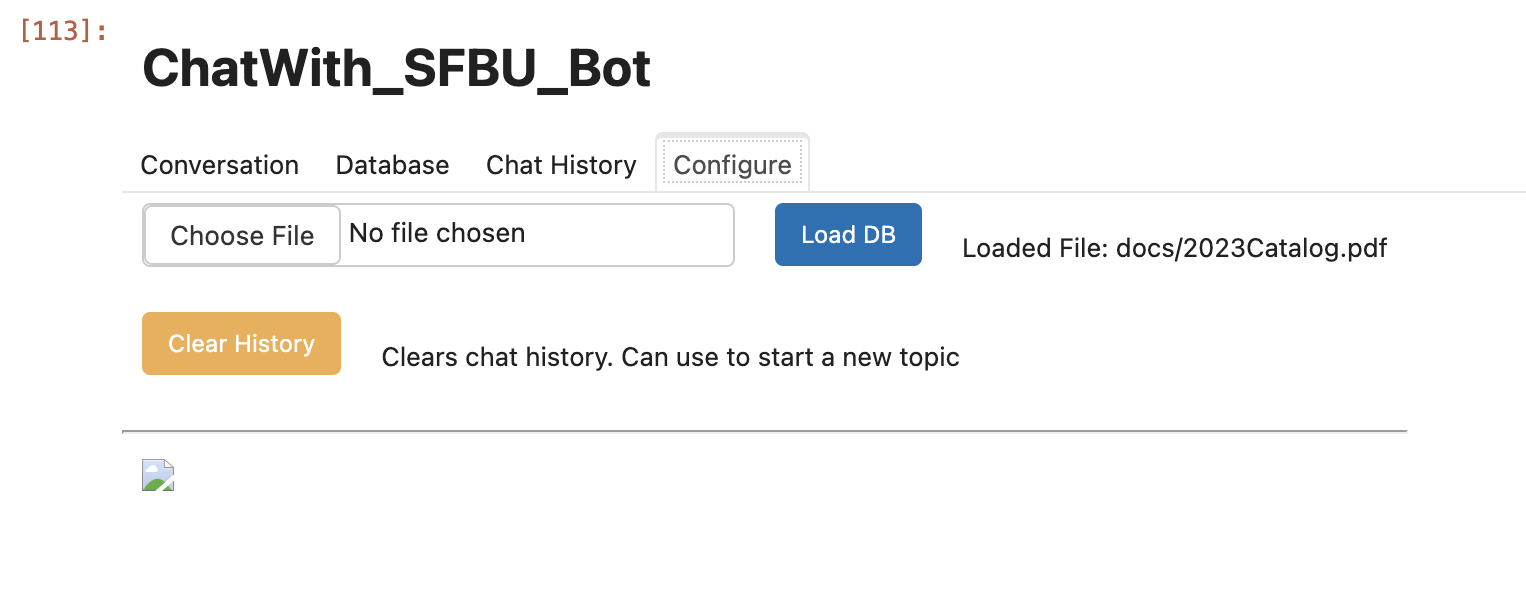